In [2]:
! pip install psycopg2-binary

In [26]:
from warnings import filterwarnings

filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import time

conn = "postgresql://jfghdjfkghjkdfg:skdjfhdskfhj@" # данные изменены
uri = "postgres.dfkjfksjhfgd:6432/dsfs" # данные изменены
conn_uri = conn + uri

# RecSys Контентный подход

### Загрузка данных

In [4]:
df_users = pd.read_sql("SELECT * FROM user_data", conn_uri)

In [5]:
df_users.head(2)

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads


In [6]:
# Берем 800 000 СЛУЧАЙНЫХ записей - больше не помещается с эмбеддингами в ограничения памяти
query_text = '''SELECT user_id, post_id, target
                FROM feed_data
                ORDER BY random() LIMIT 800000'''

In [7]:
start = time.time()

df_feeds = pd.read_sql(query_text, conn_uri)

time.time() - start

# ~1.5-2 min

119.19072318077087

In [28]:
# # В этой версии рекомендательной системы берем поле text для получения эмбеддингов BERT

df_posts = pd.read_sql("SELECT * FROM post_text_df", conn_uri)

In [29]:
df_posts.head(2)

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business


**Получение эмбеддингов BERT для поля text**

In [10]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, BertModel

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
# Инициализируем токенайзер и модель
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased')

In [12]:
# Проверяем токенайзер
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [13]:
# Класс для формирования датасета из текстовых данных
class TextData(Dataset):
    def __init__(self, texts):
        self.tokenized = tokenizer.batch_encode_plus(
            texts, 
#             add_special_tokens=True,
#             return_token_type_ids=False,
#             truncation=True
            padding='longest', 
            return_attention_mask=True, 
            return_token_type_ids=False, 
            truncation=True, 
            return_tensors='pt'
        )
        
    def __len__(self):
        return len(self.tokenized['input_ids'])
    
    def __getitem__(self, idx):
        return {key: value[idx] for key, value in self.tokenized.items()}

In [14]:
# Загрузка текстов из датафрейма в Dataloader
dataset = TextData(df_posts['text'].tolist())
# Выбераем размер пакета в зависимости от доступной памяти GPU
dataloader = DataLoader(dataset, batch_size=16)

In [15]:
# Проверяем доступность CUDA/GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Переносим модель на GPU
bert_model = bert_model.to(device)

In [16]:
# проверяем device
device

device(type='cuda')

In [17]:
# проверяем dataloader
b = next(iter(dataloader))
b

{'input_ids': tensor([[  101,  1993,  4190,  ...,     0,     0,     0],
         [  101, 15386,  1116,  ...,  1300,  1107,   102],
         [  101,  3141,   186,  ..., 14099,  8478,   102],
         ...,
         [  101, 11854, 24321,  ...,     0,     0,     0],
         [  101,   140, 11179,  ...,     0,     0,     0],
         [  101,  6250,  1715,  ...,     0,     0,     0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [18]:
# Функция для извлечения эмбеддингов
def get_embeddings(model, loader):
    model = model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader, desc="Getting embeddings")):
            batch = {k: v.to('cuda') for k, v in batch.items()}  
            outputs = model(**batch)
            if i == 0:
                embeddings = outputs.pooler_output.cpu()
            else:
                embeddings = torch.cat((embeddings, outputs.pooler_output.cpu()), dim=0)
    return embeddings

In [19]:
# Извлекаем эмбеддинги
embeddings = get_embeddings(bert_model, dataloader)

Getting embeddings: 100%|██████████| 439/439 [04:17<00:00,  1.70it/s]


In [20]:
# Оптимизируем тип данных эмбеддингов для уменьшения занимаемой памяти
embeddings = embeddings.to(torch.float16)

In [21]:
embeddings.dtype #'torch.FloatTensor'

torch.float16

In [22]:
# Меняем тип данных эмбеддингов для включения в датафрейм с признаками для обучения модели
embeddings = embeddings.numpy()

In [23]:
# Проверяем параметры эмбеддингов
embeddings.dtype, embeddings.shape

(dtype('float16'), (7023, 768))

In [30]:
# Добавляем эмбеддинги в df_posts как новые столбцы
for i in range(embeddings.shape[1]):
    df_posts[f'embed_{i}'] = embeddings[:, i]

In [31]:
df_posts.head(2)

,post_id,text,topic,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,...,embed_758,embed_759,embed_760,embed_761,embed_762,embed_763,embed_764,embed_765,embed_766,embed_767
0,1,UK economy facing major risks\n\nThe UK manufa...,business,-0.540527,0.324707,0.999023,-0.940430,0.867676,0.639160,0.916016,...,0.399414,0.243408,-0.150879,0.071594,-0.242188,-0.020660,-0.073425,1.000000,-0.200562,0.939453
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,-0.363281,0.151978,0.992676,-0.891113,0.650391,0.970215,0.557129,...,0.078491,-0.494873,0.675293,-0.828125,-0.689941,-0.725586,0.077148,0.998535,-0.864258,0.846191


**Загрузка/выгрузка постов с новыми признаками в базу данных**

In [33]:
from sqlalchemy import create_engine, text
engine = create_engine(
    "postgresql://jfghdjfkghjkdfg:skdjfhdskfhj@" # данные изменены
    "postgres.dfkjfksjhfgd:6432/dsfs" # данные изменены
)
# -> conn_uri
engine = create_engine(conn_uri)

In [ ]:
# # записываем таблицу
# start = time.time()

# df_posts.to_sql('i_n_20_embed_posts_fp3_1010', con=engine)

# time.time() - start
    
# # 46-167.9 c ~1-3 min

In [53]:
# считываем таблицу df_posts_from_sql
df_posts_from_sql = pd.read_sql('SELECT * FROM i_n_20_embed_posts_fp3_1011',
                 con=engine, index_col='index')

### Оптимизируем типы данных перед обучением для уменьшения занимаемой памяти

**users**

In [37]:
df_users.head(2)

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads


In [38]:
df_users.dtypes

user_id       int64
gender        int64
age           int64
country      object
city         object
exp_group     int64
os           object
source       object
dtype: object

In [39]:
int_types = ["int8", "int16", "int32", "int64"]
for it in int_types:
     print(np.iinfo(it))

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

Machine parameters for int32
---------------------------------------------------------------
min = -2147483648
max = 2147483647
---------------------------------------------------------------

Machine parameters for int64
---------------------------------------------------------------
min = -9223372036854775808
max = 9223372036854775807
---------------------------------------------------------------



In [40]:
col_max = df_users['exp_group'].max()
col_min = df_users['exp_group'].min()
col_min, col_max

(0, 4)

In [ ]:
# Выбираем минимальный подходящий тип для колонок int
# # df_users['user_id'] (200, 168552) -> int32
# # df_users['gender'] (0, 1)         -> int8
# # df_users['age'] (14, 95)          -> int8
# # df_users['exp_group'] (0, 4)      -> int8

In [42]:
# Меняем тип колонок int
col_int8 = ['gender', 'age', 'exp_group']
df_users[col_int8] = df_users[col_int8].astype("int8")
df_users['user_id'] = df_users['user_id'].astype("int32")

# Эффект:
# memory usage: 10.0+ MB -> 6.1+ MB

In [43]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    163205 non-null  int32 
 1   gender     163205 non-null  int8  
 2   age        163205 non-null  int8  
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int8  
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int32(1), int8(3), object(4)
memory usage: 6.1+ MB


In [45]:
# Меняем тип некоторых колонок object на category
obj_col = ['country', 'city', 'os', 'source']
df_users[obj_col] = df_users[obj_col].astype('category')

# Эффект:
# memory usage: 6.1+ MB -> 2.0 MB

In [46]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   user_id    163205 non-null  int32   
 1   gender     163205 non-null  int8    
 2   age        163205 non-null  int8    
 3   country    163205 non-null  category
 4   city       163205 non-null  category
 5   exp_group  163205 non-null  int8    
 6   os         163205 non-null  category
 7   source     163205 non-null  category
dtypes: category(4), int32(1), int8(3)
memory usage: 2.0 MB


***Итого объем занимаемой памяти датафреймом df_users уменьшен в 3 раза - с 6 до 2 Мб.***

**posts**

In [54]:
df_posts_from_sql.head(2)

,post_id,text,topic,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,...,embed_758,embed_759,embed_760,embed_761,embed_762,embed_763,embed_764,embed_765,embed_766,embed_767
index,,,,,,,,,,,,,,,,,,,,,
0,1,UK economy facing major risks\n\nThe UK manufa...,business,-0.540527,0.324707,0.999023,-0.940430,0.867676,0.639160,0.916016,...,0.399414,0.243408,-0.150879,0.071594,-0.242188,-0.020660,-0.073425,1.000000,-0.200562,0.939453
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,-0.363281,0.151978,0.992676,-0.891113,0.650391,0.970215,0.557129,...,0.078491,-0.494873,0.675293,-0.828125,-0.689941,-0.725586,0.077148,0.998535,-0.864258,0.846191


In [55]:
df_posts_from_sql.dtypes

post_id        int64
text          object
topic         object
embed_0      float64
embed_1      float64
              ...   
embed_763    float64
embed_764    float64
embed_765    float64
embed_766    float64
embed_767    float64
Length: 771, dtype: object

In [56]:
df_posts_from_sql.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7023 entries, 0 to 7022
Columns: 771 entries, post_id to embed_767
dtypes: float64(768), int64(1), object(2)
memory usage: 41.4+ MB


In [57]:
# Меняем тип колонки int
df_posts_from_sql['post_id'] = df_posts_from_sql['post_id'].astype("int16")

In [59]:
# Меняем тип колонки topic с object на category
df_posts_from_sql['topic'] = df_posts_from_sql['topic'].astype('category')

In [63]:
float_cols = df_posts_from_sql.select_dtypes(include=['float'])
# float_cols

In [64]:
# Уменьшаем разрядность колонок float до минимально возможной
for col in float_cols.columns:
    df_posts_from_sql[col] = pd.to_numeric(df_posts_from_sql[col], downcast='float')

# Эффект:
# memory usage: 41.4+ MB -> 20.7+ MB

In [65]:
df_posts_from_sql.dtypes

post_id         int16
text           object
topic        category
embed_0       float32
embed_1       float32
               ...   
embed_763     float32
embed_764     float32
embed_765     float32
embed_766     float32
embed_767     float32
Length: 771, dtype: object

In [66]:
df_posts_from_sql.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7023 entries, 0 to 7022
Columns: 771 entries, post_id to embed_767
dtypes: category(1), float32(768), int16(1), object(1)
memory usage: 20.7+ MB


***Итого объем занимаемой памяти датафреймом df_posts уменьшен в 2 раза - с ~40 до ~20 Мб.***

**feeds**

In [67]:
df_feeds.head(2)

,user_id,post_id,target
0,31408,4499,0
1,59054,1057,1


In [68]:
df_feeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  800000 non-null  int64
 1   post_id  800000 non-null  int64
 2   target   800000 non-null  int64
dtypes: int64(3)
memory usage: 18.3 MB


In [69]:
df_feeds.dtypes

user_id    int64
post_id    int64
target     int64
dtype: object

In [ ]:
# Выбираем минимальный подходящий тип для колонок int
# # df_feeds['user_id'] (200, 168552) -> int32
# # df_feeds['post_id'] (1, 7319)     -> int16
# # df_feeds['target'] (0, 1)         -> int8

In [70]:
# Меняем тип колонок int
df_feeds['user_id'] = df_feeds['user_id'].astype("int32")
df_feeds['post_id'] = df_feeds['post_id'].astype("int16")
df_feeds['target'] = df_feeds['target'].astype("int8")

# Эффект:
# memory usage: 18.3 MB -> 5.3 MB

In [71]:
df_feeds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  800000 non-null  int32
 1   post_id  800000 non-null  int16
 2   target   800000 non-null  int8 
dtypes: int16(1), int32(1), int8(1)
memory usage: 5.3 MB


***Итого объем занимаемой памяти датафреймом df_feeds уменьшен более чем в 3 раза - с ~18 до ~5 Мб.***

### Собираем в 1 фрейм

In [72]:
# Убираем лишнюю колонку text
df_posts_bert_text = df_posts_from_sql.drop('text', axis=1)

In [73]:
df = pd.merge(df_feeds, df_posts_bert_text, left_on='post_id', right_on='post_id')

In [74]:
df = pd.merge(df, df_users, left_on='user_id', right_on='user_id')

In [75]:
df.head(2)

,user_id,post_id,target,topic,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,...,embed_765,embed_766,embed_767,gender,age,country,city,exp_group,os,source
0,31408,4499,0,movie,-0.598145,0.369873,0.999512,-0.985352,0.941895,0.884277,...,1.0,-0.778809,0.971680,1,44,Russia,Moscow,1,Android,ads
1,31408,5769,0,movie,-0.571289,0.434570,0.999512,-0.989746,0.937012,0.953613,...,1.0,-0.873047,0.986816,1,44,Russia,Moscow,1,Android,ads


In [76]:
df.shape

(800000, 779)

In [77]:
df.info()

# !!! memory usage: 2.3 GB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 779 entries, user_id to source
dtypes: category(5), float32(768), int16(1), int32(1), int8(4)
memory usage: 2.3 GB


### Тренируем модель

In [79]:
# Убираем лишние колонки для обучения
df_learn = df.drop(['user_id', 'post_id'], axis=1)

X = df_learn.drop('target', axis=1)
y = df_learn['target']

In [80]:
df_learn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Columns: 777 entries, target to source
dtypes: category(5), float32(768), int8(4)
memory usage: 2.3 GB


In [81]:
# Делим выборку на train-test
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=True,
                                                    test_size=0.2)

In [83]:
X_train.shape

(640000, 776)

In [36]:
from catboost import CatBoostClassifier

# Выделяем колонки, которые передадим в catboost как категориальные
cat_cols = ['topic', 'country', 'city', 'os', 'source']
# Ниже показана гигантская разница по времени обучения при включении использования GPU
catboost = CatBoostClassifier(verbose=50, task_type="GPU", devices='0:1')
# Параметры, определенные в ходе длительных экспериментов с GreedSearchCV
catboost.set_params(depth=12, learning_rate=0.18, auto_class_weights='Balanced',
                    iterations=500, border_count=200, l2_leaf_reg=3)

catboost.fit(X_train, y_train, cat_features=cat_cols)

# Разница во времени обучения на CPU и GPU:
# CPU -- remaining: 2h 20m 28s
# GPU -- remaining: 8m 42s !!!

0:	learn: 0.6823856	total: 1.05s	remaining: 8m 42s
50:	learn: 0.5845885	total: 37.4s	remaining: 5m 29s
100:	learn: 0.5159853	total: 1m 14s	remaining: 4m 53s
150:	learn: 0.4613092	total: 1m 51s	remaining: 4m 17s
200:	learn: 0.4115900	total: 2m 29s	remaining: 3m 41s
250:	learn: 0.3692766	total: 3m 6s	remaining: 3m 5s
300:	learn: 0.3342049	total: 3m 44s	remaining: 2m 28s
350:	learn: 0.3027675	total: 4m 22s	remaining: 1m 51s
400:	learn: 0.2744083	total: 5m	remaining: 1m 14s
450:	learn: 0.2501083	total: 5m 39s	remaining: 36.9s
499:	learn: 0.2287059	total: 6m 16s	remaining: 0us


409.00615096092224

In [37]:
# # Подсчет F1-меры c использованием параметра average='weighted'
f1_score(y_test, catboost.predict(X_test), average='weighted')

0.807772566014907

In [38]:
# смотрим метрики
print(classification_report(y_test, catboost.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.901     0.866     0.883    142838
           1      0.159     0.211     0.181     17162

    accuracy                          0.795    160000
   macro avg      0.530     0.538     0.532    160000
weighted avg      0.822     0.795     0.808    160000



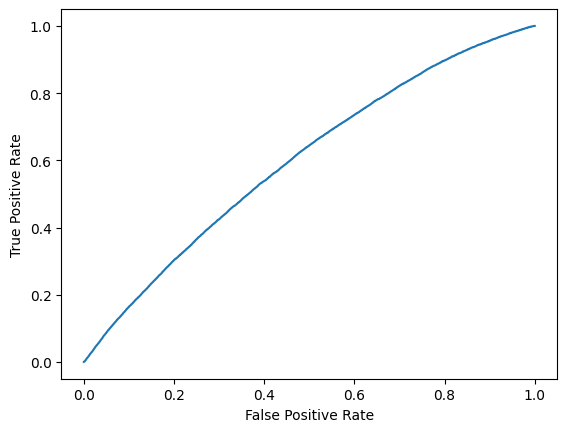

In [39]:
# строим RocCurve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, thresholds = roc_curve(y_test, catboost.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [40]:
# считаем auc
round(auc(fpr, tpr), 3)

0.599

In [41]:
# смотрим признаки, наиболее повлиявшие на качество
catboost.get_feature_importance(prettified=True)

,Feature Id,Importances
0,city,12.558543
1,age,9.411790
2,exp_group,7.670538
3,gender,4.949240
4,source,3.779235
...,...,...
771,embed_744,0.000000
772,embed_745,0.000000
773,embed_751,0.000000
774,embed_752,0.000000


In [42]:
# Запись модели в файл

catboost.save_model('model_catboost_BERT')